In [13]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mopet import mopet

from synchronization import experiments
from synchronization import plots
from synchronization import runner
from synchronization import constants

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Effect of uncorrelated noise on coupled EI networks

Hypothesis
* in certain parameter regimes the EI networks synchronize while within synchronization decreases
* only a fraction of the neurons in a network spike in each cycle, we see a widened voltage distribution

Setup
* 2 coupled network case
* independent noise with varying strengths

Metrics & Visualization
* overlap in peak frequency in power spectrum indicates synchronization
* local and global order parameter quantify synchronization respectively
* optional: mean phase coherence

Run for different noise strenghts and plot PSD spectra of all runs.
A handful of parameter sets should suffice to get a first intuition. Afterwards we can do an exhaustive parameter exploration.

In [3]:
factor = 1

# overwriting default parameters
default_params = {

  # synaptic coupling strengths, most important parameters for tuning PING mechanism
  "J_itoi": 3.0 * factor,
  "J_etoe": 0.1 * factor,
  "J_etoi": 0.5 * factor,
  "J_itoe": 10.0 * factor,

  "runtime": 1000.0,

  "N_e": 1000,
  "N_i": 250,

  "ou_enabled": [False, False],

  # Independent spike trains generated by Poisson Point Process for each target neuron
  "poisson_enabled": [True, True],
  "poisson_variance": 1.0,
   # noise frequency ration between networks
  "poisson_p": 0.83,

  # 200 Hz as in Meng et al.
  "poisson_mean_input": 200, 

  # Neuron size of each Poisson Group
  "poisson_size": 800,
  
  "J_ppee": 2.0,
  # increase from 0.1 to 0.2 increases mainly amplitude
  "J_ppei": 2.0,

  # if set to default of 0.1 this leads to strange split in frequency band
  "const_delay": 0.2,
   "N_pop": 2,

   "p_etoe": 0.1,
   "p_etoi": 0.4,
   "p_itoe": 0.1,
   "p_itoi": 0.4,
}

params = {
  "poisson_variance": np.arange(0.1, 6, 0.5),
  "poisson_p": np.arange(0.75, 1, .025),
}

varying_params = list(params.keys())

In [4]:
ex = mopet.Exploration(
    runner.run_in_mopet, 
    explore_params=params, 
    default_params=default_params,
    hdf_filename=constants.MODELS_PATH + "/uncorrelated_noise.h5"
    exploration_name="uncorrelated_noise"
)

In [5]:
ex.run()

24s
(pid=78296) ==== Network Run Finished ====
(pid=78296) runtime: 39.7
(pid=78296) Starting Aggregation ...
 74%|███████▍  | 89/120 [05:09<01:07,  2.17s/it](pid=78296) Initializing net ...
(pid=78296) Poisson rate for network 1:  9.803921568627452
(pid=78296) Poisson rate for network 2:  9.803921568627452
(pid=78296) Initialization time: 0.5071489810943604s
(pid=78296) ==== Running Network ... ====
(pid=78304) Starting simulation at t=0. s for a duration of 1. s
(pid=78297) Starting simulation at t=0. s for a duration of 1. s
(pid=78300) Starting simulation at t=0. s for a duration of 1. s
(pid=78298) Starting simulation at t=0. s for a duration of 1. s
(pid=78299) Starting simulation at t=0. s for a duration of 1. s
(pid=78295) Starting simulation at t=0. s for a duration of 1. s
(pid=78294) Starting simulation at t=0. s for a duration of 1. s
(pid=78292) Starting simulation at t=0. s for a duration of 1. s
(pid=78301) Starting simulation at t=0. s for a duration of 1. s
(pid=78303)

In [6]:
ex.load_results(all=True)

ex.explore_params
ex.results.keys()

100%|██████████| 120/120 [00:10<00:00, 11.42it/s]


dict_keys([0, 1, 10, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 11, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 12, 13, 14, 15, 16, 17, 18, 19, 2, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 3, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 5, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 6, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 8, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 9, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [7]:
ex.df["freq_diff"] = np.abs(ex.df["peak_freq"] - ex.df["peak_freq_2"])
ex.df[["peak_freq", "peak_freq_2", "max_amplitude", "max_amplitude_2", "freq_diff"]]

,peak_freq,peak_freq_2,max_amplitude,max_amplitude_2,freq_diff
0,4.0,2.0,38.634245,44.714505,2.0
1,82.0,76.0,39.650909,48.593760,6.0
10,78.0,60.0,34.874683,33.370653,18.0
100,82.0,68.0,21.562674,27.186462,14.0
101,80.0,66.0,10.414262,39.929350,14.0
...,...,...,...,...,...
95,82.0,70.0,20.902509,29.386278,12.0
96,78.0,86.0,17.235461,19.323886,8.0
97,80.0,84.0,20.054297,21.125090,4.0
98,74.0,96.0,17.976864,18.304517,22.0


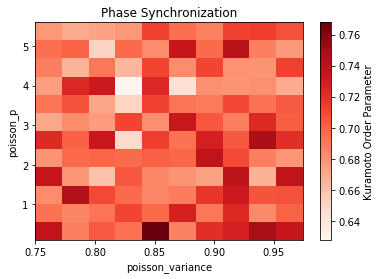

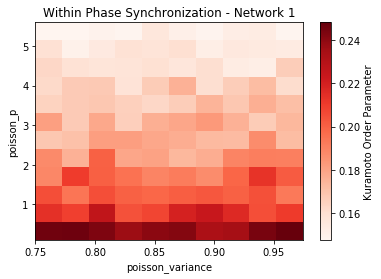

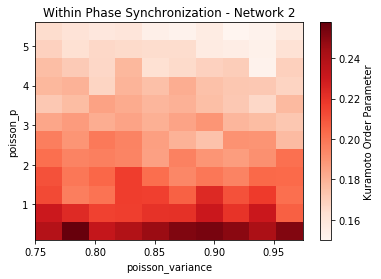

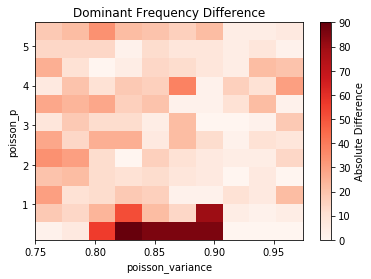

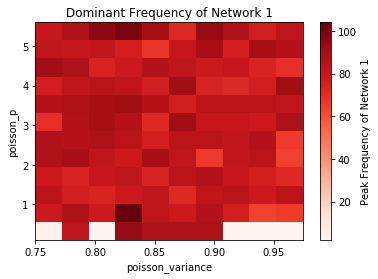

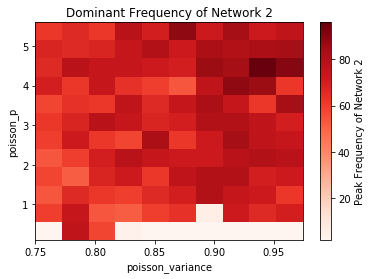

In [8]:
# phase synchronization
pivoted_synch = ex.df.pivot_table(values='phase_synchronization', index='poisson_variance', columns='poisson_p', aggfunc='first')
plots.heat_map_pivoted(
    pivot_table=pivoted_synch,
    extent=[min(ex.df.poisson_p), max(ex.df.poisson_p), min(ex.df.poisson_variance), max(ex.df.poisson_variance)],
    title="Phase Synchronization",
    colorbar="Kuramoto Order Parameter"
)

# within phase synchronization of net 1
pivoted_synch = ex.df.pivot_table(values='plv_net_1', index='poisson_variance', columns='poisson_p', aggfunc='first')
plots.heat_map_pivoted(
    pivot_table=pivoted_synch,
    extent=[min(ex.df.poisson_p), max(ex.df.poisson_p), min(ex.df.poisson_variance), max(ex.df.poisson_variance)],
    title="Within Phase Synchronization - Network 1",
    colorbar="Kuramoto Order Parameter"
)

# within phase synchronization of net 2
pivoted_synch = ex.df.pivot_table(values='plv_net_2', index='poisson_variance', columns='poisson_p', aggfunc='first')
plots.heat_map_pivoted(
    pivot_table=pivoted_synch,
    extent=[min(ex.df.poisson_p), max(ex.df.poisson_p), min(ex.df.poisson_variance), max(ex.df.poisson_variance)],
    title="Within Phase Synchronization - Network 2",
    colorbar="Kuramoto Order Parameter"
)

# freq diff
plots.heat_map_pivoted(
    pivot_table=ex.df.pivot_table(values='freq_diff', index='poisson_variance', columns='poisson_p', aggfunc='first'),
    extent=[min(ex.df.poisson_p), max(ex.df.poisson_p), min(ex.df.poisson_variance), max(ex.df.poisson_variance)],
    title="Dominant Frequency Difference",
    colorbar='Absolute Difference'
)

# dom freq of network 1
pivoted_A = ex.df.pivot_table(values='peak_freq', index='poisson_variance', columns='poisson_p', aggfunc='first')
plots.heat_map_pivoted(
    pivot_table=pivoted_A,
    extent=[min(ex.df.poisson_p), max(ex.df.poisson_p), min(ex.df.poisson_variance), max(ex.df.poisson_variance)],
    title="Dominant Frequency of Network 1",
    colorbar='Peak Frequency of Network 1'
)

# dom freq of network 2
pivoted_B = ex.df.pivot_table(values='peak_freq_2', index='poisson_variance', columns='poisson_p', aggfunc='first')
plots.heat_map_pivoted(
    pivot_table=pivoted_B,
    extent=[min(ex.df.poisson_p), max(ex.df.poisson_p), min(ex.df.poisson_variance), max(ex.df.poisson_variance)],
    title="Dominant Frequency of Network 2",
    colorbar='Peak Frequency of Network 2'
)

In [9]:
for key, model in ex.results.items():
    row = ex.df.iloc[key]

    title = ""
    for param in varying_params:
        title += f" {param}: {row[param]}"

#     plots.psd(model, title=f"PSD of 1st network - {title}", population=1, duration=1000)
    # plots.psd(model, title=f"PSD of 2nd network - {title}", population=2, duration=1000)

    # TODO: raster plots take too much memory and crash vs code currently ...
    # plots.raster(title="Raster of 1st network", model=model)
    # plots.raster(title="Raster of 2nd network", model=model, population=2)

In [10]:
data = list([(ex.df.iloc[key][param], item) for key, item in ex.results.items()])
titles, models = zip(*data)

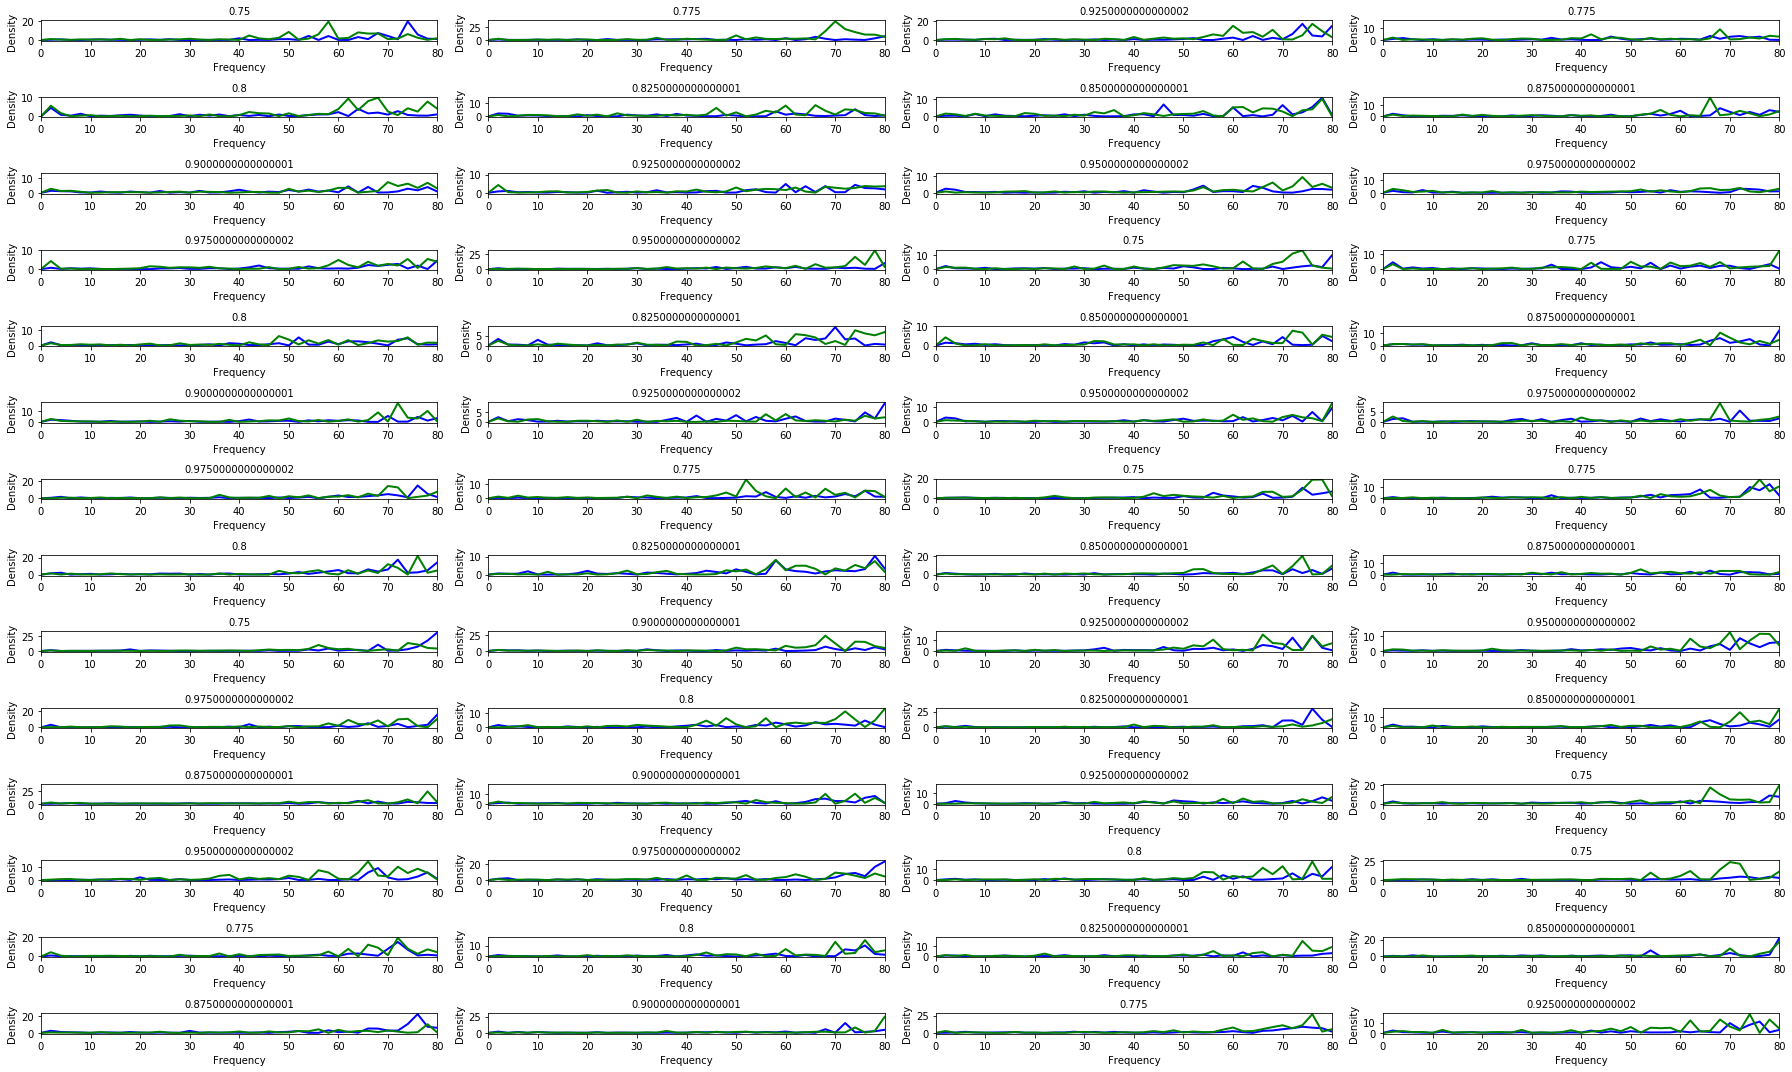

In [11]:
plots.all_psd(data, n_cols=14, n_rows=4, figsize=(25, 15))
plt.show()

(<Figure size 720x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1347e9dd0>)

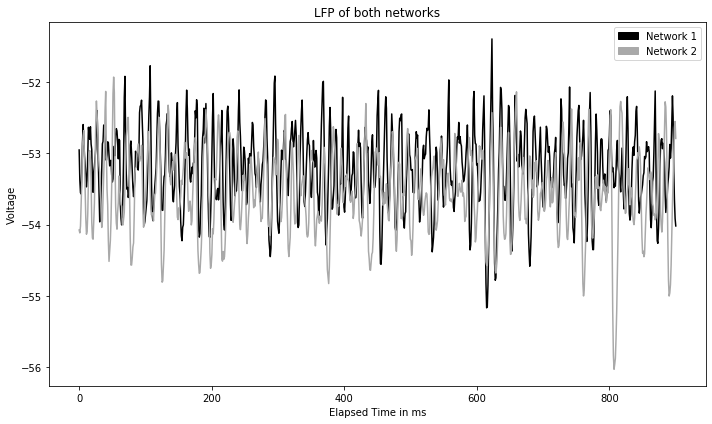

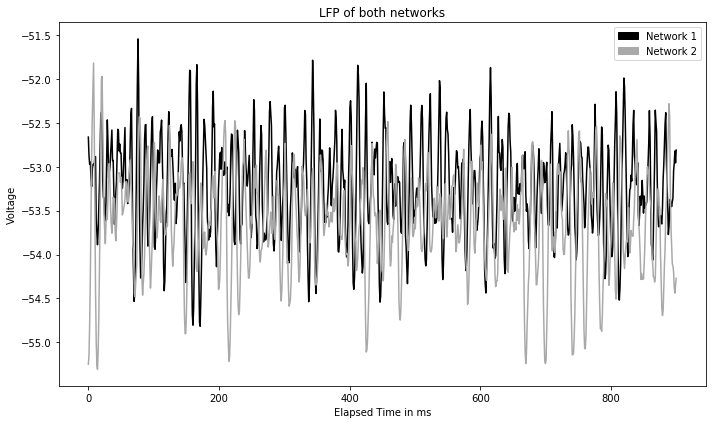

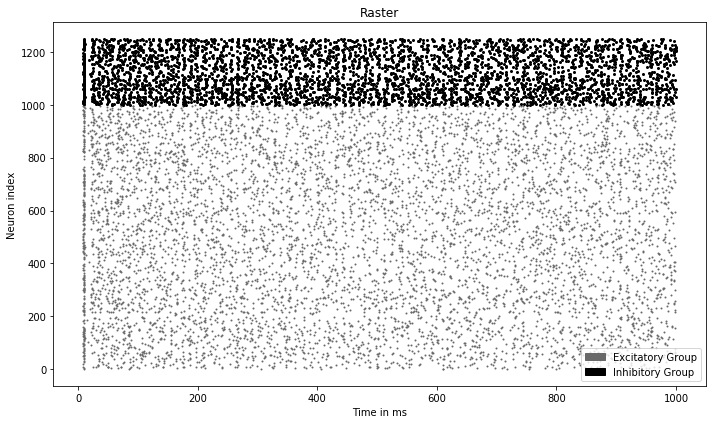

In [12]:
# no activity  -> subthreshold
plots.lfp_nets(models[0], skip = 100)

# high frequency oscillation
plots.lfp_nets(models[2], skip = 100)
plots.raster(models[2])

# high frequency oscillation
# plots.lfp_nets(models[6])
# plots.raster(models[6])

1. Next steps for parameter exploration:
    * run on server or on my second computer
 
2. Next steps to analyze and compare specific parameter sets
    * use different notebook to experiment and analyze specific sets
    * reduce complexity of model -> smaller number of neurons, only one network, etc.

Analyze spike time variability

* plot voltage trace of a single neuron to see when it spikes

Okay, what are the most important next steps?

1. Need to aggregate data to understand parameter exploration results
2. Look at increasing noise and analyze in detail -> Sunday

3. Run parameter exploration and see if network 1 and network 2 synchronize at some point!